# GROVER'S ALGORITHM

## 1. Problem definition


Grover's algorithm addresses the problem of searching an unsorted database or an unordered list with $N$ items. The problem statement is as follows:
- Given a function $f(x)$ that returns 1 if $x$ is the searched element and 0 otherwise (oracle), find an input $x^*$ such that $f(x^*) = 1$

On average, a classical algorithm must evaluate the function $f(x)$ $N/2$ times until $x^*$ is found and in the worst case, it must evaluate every possible input ($N$ times).

More formally:

* The domain of the function is $x \in \{0,1\}^n$, with $N = 2^n$ possible inputs.
* The oracle function satisfies:
$$
f(x) =
\begin{cases}
1 & \text{if } x = x^*, \\
0 & \text{otherwise}.
\end{cases}
$$

The goal is to determine the value of $x^*$ using the minimum possible number of evaluations of the oracle $f(x)$.

Classically, no algorithm can do better than linear search for this problem when no additional structure of the function is known. Therefore, the optimal classical complexity is $O(N)$.

# 2. Grover's algorithm

Unlike the classical approach, Grover’s algorithm does not test each possible input one by one. Instead, it exploits quantum superposition and interference to increase the probability of measuring the correct solution. It's important to note that the algorithm doesn't point to the answer directly, instead, it iteratively boosts the probability of measuring the correct result while suppressing the incorrect ones.

At a high level, the algorithm works as follows:
1. **Initialization and superposition:** the algorithm starts by preparing a quantum state that represents a uniform superposition of all possible inputs.

2. **Oracle:** the oracle identifies the target state $x^*$ and flips its phase.

3. **Diffusion:** a diffusion operator is applied to perform an inversion about the mean, increasing the amplitude of $x^*$

4. **Iteration:** steps 2 and 3 are repeated approximately $\frac{\pi}{4}\sqrt{N}$ times.

5. **Measurement:** a measurement is performed and the correct solucion is obtained with high probability. Excessive iterations will lead to over-rotation, causing the probability of measuring the correct state to decline.

By following these steps, Grover’s algorithm concentrates probability on the desired state. As a consequence, the number of required oracle evaluations is reduced from the classical $O(N)$ to $O(\sqrt{N})$, achieving a quadratic speedup for unstructured search problems.

The algorithm is particularly useful in scenarios where the search space is large, such as:
- Finding a specific item in a large database.

- Solving NP-complete problems by searching for solutions among many possibilities.

- Cryptographic applications, such as breaking symmetric key cryptography by searching for the key.

Comparison in time complexity between $O(N)$ and $O(\sqrt{N})$:

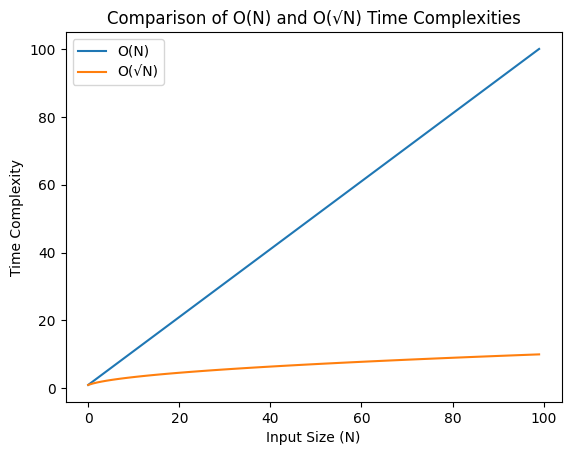

In [50]:
from utils.plot import plot_complexities

plot_complexities()

## 3. Circuit implementation

To implement this algorithm in a quantum computer, it is useful to express the binary strings as states. Therefore, the states we will be looking for are: 
$$\{|x_i^*\rangle\}\in|\Sigma^n\rangle$$
In order to build the curcuit, we will follow the following steps: 

**1 - Initialization and superposition:** we prepare $n$ qubits in the $|0\rangle$ state and apply a Hadamard gate to each of them in order to create 
a uniform superposition of all $N = 2^n$ basis states. The resulting state is: 

$$ |\psi_0\rangle = \frac{1}{\sqrt{N}} \sum_{x=0}^{N-1} |x\rangle $$

**2 - Oracle:** the oracle (black box) identifies the target states $\{x_i^*\}$ and flips their phases. As a result, the amplitudes of the marked states acquire a phase of $-1$, while all other states remain unchanged. Its action on a basis state can be written as: 

$$ U_f |x\rangle = (-1)^{f(x)} |x\rangle $$

**3 - Diffusion:** after the oracle marks the target states, a diffusion operator is applied to amplify their amplitudes. The diffusion operator, also known as the inversion about the mean, is defined as:

$$
D = 2|\psi_0\rangle\langle\psi_0| - I
= H^{\otimes n}\left(2|0\rangle\langle 0| - I\right)H^{\otimes n}.
$$

where $|\psi_0\rangle$ is the uniform superposition state and $I$ is the identity operator.

In practice, the operator $2|0\rangle\langle 0| - I$ corresponds to a reflection about the state $|0\ldots0\rangle$. However, in quantum circuits it is more convenient to implement a phase flip on the state $|1\ldots1\rangle$ using a multi-controlled $Z$ gate. For this reason, a basis change is introduced using Pauli-$X$ gates, which map $|0\ldots0\rangle$ to $|1\ldots1\rangle$:

$$
X^{\otimes n} |0\ldots0\rangle = |1\ldots1\rangle.
$$

This allows the diffusion operator to be implemented as:
$$
D =
H^{\otimes n}
X^{\otimes n}
\left(2|1\ldots1\rangle\langle 1\ldots1| - I\right)
X^{\otimes n}
H^{\otimes n},
$$
where the central operator is realized using a multi-controlled $Z$ gate.

This operator reflects the amplitudes of all states about their average value. If $a_x$ denotes the amplitude of the state $|x\rangle$ before diffusion and $\bar{a}$ is the mean amplitude,

$$
\bar{a} = \frac{1}{N} \sum_{x=0}^{N-1} a_x,
$$

then the diffusion operator transforms each amplitude as:

$$
a_x \;\longrightarrow\; 2\bar{a} - a_x.
$$

As a consequence, amplitudes of the marked states (which were reduced by the oracle) are increased, while amplitudes of the unmarked states are decreased. This process is known as amplitude amplification.


**4 - Iteration:** steps 2 and 3 are repeated. The optimal number of iterations can be obtained from the condition: 

$$ (2t+1)\theta = (2t+1)\sin^{-1}\!\left(\sqrt{\frac{|A_1|}{N}}\right) \;\approx\; (2t+1)\sqrt{\frac{|A_1|}{N}} \;\approx\; \frac{\pi}{2}. $$ Solving for $t$ gives: $$ t \;\approx\; \frac{\pi}{4}\sqrt{\frac{N}{|A_1|}} - \frac{1}{2}. $$ 

Where $A_1$ is the number of solutions.

**5 - Measurement:** after applying the optimal number of Grover iterations, a measurement is performed in the computational basis.  
At this stage, the quantum state is highly concentrated on the marked states $\{|x_i^*\rangle\}$, meaning that their measurement probabilities are close to 1.

If $|\psi_t\rangle$ denotes the state after $t$ Grover iterations, the probability of measuring a marked state is:
$$
P(x \in \{x_i^*\}) = \sum_{x_i^*} |\langle x_i^* | \psi_t \rangle|^2 \approx 1.
$$

Therefore, measuring the system yields one of the target states $x_i^*$ with high probability.  In practice, due to noise and finite sampling, the circuit is usually executed multiple times (shots), and the most frequently observed outcome is taken as the solution.


## 4. Example

To illustrate how Grover’s algorithm works in practice, we consider a simple example with $n = 2$ qubits, corresponding to a search space of $N = 4$ possible states. This small instance allows us to clearly visualize the effect of each step of the algorithm and to understand how the amplitudes of the quantum states evolve during the process.

We begin by recalling the definitions of some of the basic quantum gates: the $X$, $Z$, Hadamard ($H$), and controlled-$Z$ ($CZ$) gates.

The Pauli-$X$ gate acts as a quantum NOT gate, flipping the state of a qubit:
$$
X =
\begin{pmatrix}
0 & 1 \\
1 & 0
\end{pmatrix}
$$

The Pauli-$Z$ gate applies a phase flip to the state $|1\rangle$ while leaving $|0\rangle$ unchanged:
$$
Z =
\begin{pmatrix}
1 & 0 \\
0 & -1
\end{pmatrix}
$$

The Hadamard gate creates superposition by mapping computational basis states into equal-weight linear combinations:
$$
H =
\frac{1}{\sqrt{2}}
\begin{pmatrix}
1 & 1 \\
1 & -1
\end{pmatrix}
$$

The controlled-$Z$ ($CZ$) gate applies a $Z$ gate only when both qubits are in the state $|1\rangle$. In the computational basis $\{|00\rangle, |01\rangle, |10\rangle, |11\rangle\}$, it is represented as:
$$
CZ =
\begin{pmatrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & -1
\end{pmatrix}
$$


We must also recall the tensor product. It allows us to describe composite quantum systems. Given two vectors
$$
|a\rangle =
\begin{pmatrix}
a_1 \\
a_2
\end{pmatrix},
\qquad
|b\rangle =
\begin{pmatrix}
b_1 \\
b_2
\end{pmatrix},
$$
their tensor product is defined as:
$$
|a\rangle \otimes |b\rangle =
\begin{pmatrix}
a_1 b_1 \\
a_1 b_2 \\
a_2 b_1 \\
a_2 b_2
\end{pmatrix}
$$

In general, for vectors $|a\rangle \in \mathbb{C}^m$ and $|b\rangle \in \mathbb{C}^n$, the tensor product $|a\rangle \otimes |b\rangle$ is a vector in $\mathbb{C}^{mn}$.

The tensor product can also be defined for matrices.  
Given two matrices $A \in \mathbb{C}^{m \times m}$ and $B \in \mathbb{C}^{n \times n}$, their tensor product $A \otimes B$ is a matrix in $\mathbb{C}^{mn \times mn}$ defined as:
$$
A \otimes B =
\begin{pmatrix}
a_{11} B & a_{12} B & \cdots & a_{1m} B \\
a_{21} B & a_{22} B & \cdots & a_{2m} B \\
\vdots   & \vdots   & \ddots & \vdots   \\
a_{m1} B & a_{m2} B & \cdots & a_{mm} B
\end{pmatrix}
$$

This operation allows us to construct multi-qubit states and operators from single-qubit ones. 
For example, the state of two qubits is obtained as $|q_1 q_2\rangle = |q_1\rangle \otimes |q_2\rangle$, and multi-qubit gates are built using tensor products of single-qubit gates.



Now we run the algorithm searching for $|x^*\rangle=|11\rangle$. We start with the state:
$$ 
|\psi_0\rangle=|00\rangle=
\begin{pmatrix}
1 \\
0 \\
0 \\
0
\end{pmatrix}
$$ 

In order to explore all possible states simultaneously, we must create a uniform superposition. This is achieved by applying a Hadamard gate to each qubit, which corresponds to applying the operator $H \otimes H$ to the initial state. We start by calculating the operator:

$$
(H \otimes H) =
\frac{1}{2}
\begin{pmatrix}
1 & 1 \\
1 & -1
\end{pmatrix}
\otimes
\begin{pmatrix}
1 & 1 \\
1 & -1
\end{pmatrix}
=
\frac{1}{2}
\begin{pmatrix}
1 & 1 & 1 & 1 \\
1 & -1 & 1 & -1 \\
1 & 1 & -1 & -1 \\
1 & -1 & -1 & 1
\end{pmatrix}
$$

Applying this operator to the initial state produces the uniform superposition of all computational basis states:
$$
|\psi_1\rangle = (H \otimes H)|00\rangle
= 
\frac{1}{2}
\begin{pmatrix}
1 & 1 & 1 & 1 \\
1 & -1 & 1 & -1 \\
1 & 1 & -1 & -1 \\
1 & -1 & -1 & 1
\end{pmatrix}
\begin{pmatrix}
1 \\
0 \\
0 \\
0
\end{pmatrix}
=
\frac{1}{2}
\begin{pmatrix}
1 \\
1 \\
1 \\
1
\end{pmatrix}
= \frac{1}{2} \left( |00\rangle + |01\rangle + |10\rangle + |11\rangle \right).
$$

Next, we apply the oracle to mark the target state by flipping the phase of $|11\rangle$. This requires an operator that acts  only on that specific basis state while leaving all others unchanged. For this purpose, we use the controlled-$Z$ ($CZ$) gate:


$$
|\psi_2\rangle = CZ|\psi_1\rangle
= 
\frac{1}{2}
\begin{pmatrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & -1
\end{pmatrix}
\begin{pmatrix}
1 \\
1 \\
1 \\
1
\end{pmatrix}
=
\frac{1}{2}
\begin{pmatrix}
1 \\
1 \\
1 \\
-1
\end{pmatrix}
= \frac{1}{2} \left( |00\rangle + |01\rangle + |10\rangle - |11\rangle \right).
$$

Now we apply the diffusion operator $ D $:

$$
|\psi_3\rangle =
D|\psi_2\rangle = 
\left[ H^{\otimes 2}\left(2|00\rangle\langle 00| - I\right)H^{\otimes 2} \right] |\psi_2\rangle
$$

We compute the action step by step:

1) First Hadamards:
$$
\left[ H \otimes H \right] |\psi_2\rangle
=
\frac{1}{2}
\begin{pmatrix}
1 & 1 & 1 & 1 \\
1 & -1 & 1 & -1 \\
1 & 1 & -1 & -1 \\
1 & -1 & -1 & 1
\end{pmatrix}
\cdot
\frac{1}{2}
\begin{pmatrix}
1\\
1\\
1\\
-1
\end{pmatrix}
=
\begin{pmatrix}
\frac{1}{2}\\
\frac{1}{2}\\
\frac{1}{2}\\
-\frac{1}{2}
\end{pmatrix}
$$

2) Apply $\left(2|00\rangle\langle 00| - I\right)$:
$$
\left(2|00\rangle\langle 00| - I\right)
\begin{pmatrix}
\frac{1}{2}\\
\frac{1}{2}\\
\frac{1}{2}\\
-\frac{1}{2}
\end{pmatrix}
=
\begin{pmatrix}
1 & 0 & 0 & 0 \\
0 & -1 & 0 & 0 \\
0 & 0 & -1 & 0 \\
0 & 0 & 0 & -1
\end{pmatrix}
\begin{pmatrix}
\frac{1}{2}\\
\frac{1}{2}\\
\frac{1}{2}\\
-\frac{1}{2}
\end{pmatrix}
=
\begin{pmatrix}
\frac{1}{2}\\
-\frac{1}{2}\\
-\frac{1}{2}\\
\frac{1}{2}
\end{pmatrix}
$$

3) Final Hadamards:
$$
|\psi_3\rangle
=
\left[ H \otimes H \right] |\psi_2\rangle
\begin{pmatrix}
\frac{1}{2}\\
-\frac{1}{2}\\
-\frac{1}{2}\\
\frac{1}{2}
\end{pmatrix}
=
\frac{1}{2}
\begin{pmatrix}
1 & 1 & 1 & 1 \\
1 & -1 & 1 & -1 \\
1 & 1 & -1 & -1 \\
1 & -1 & -1 & 1
\end{pmatrix}
\begin{pmatrix}
\frac{1}{2}\\
-\frac{1}{2}\\
-\frac{1}{2}\\
\frac{1}{2}
\end{pmatrix}
=
\begin{pmatrix}
0\\
0\\
0\\
1
\end{pmatrix}
= |11\rangle
$$

Therefore, after applying the diffusion operator, the amplitude is maximally concentrated on the target state $|11\rangle$, which will be obtained with the highest probability upon measurement (in this particular case 100% probability).



At first glance, it may seem that the choice of the target state $|11\rangle$ is particularly convenient, since the $CZ$ gate directly flips its phase. However, this does not restrict the applicability of the algorithm.

If we want to mark a different target state, the oracle can be easily adapted by applying single-qubit gates that map the desired state to $|11\rangle$, followed by the $CZ$ gate, and then undoing the mapping. In this way, any computational basis state can be marked without difficulty.

For example, if the target state is $|00\rangle$, the oracle can be constructed as:
$$
U_f = (X \otimes X)\, CZ \, (X \otimes X)
$$

To make this explicit, consider an arbitrary two-qubit state:
$$
|\psi\rangle =
\begin{pmatrix}
a \\
b \\
c \\
d
\end{pmatrix}
$$

First, apply $X \otimes X$:
$$
(X \otimes X)|\psi\rangle
=
\left[
\begin{pmatrix}
0 & 1 \\
1 & 0
\end{pmatrix}
\otimes
\begin{pmatrix}
0 & 1 \\
1 & 0
\end{pmatrix}
\right]
|\psi\rangle
 =
\begin{pmatrix}
0 & 0 & 0 & 1 \\
0 & 0 & 1 & 0 \\
0 & 1 & 0 & 0 \\
1 & 0 & 0 & 0
\end{pmatrix}
\begin{pmatrix}
a \\
b \\
c \\
d
\end{pmatrix}
=
\begin{pmatrix}
d \\
c \\
b \\
a
\end{pmatrix}
$$

Next, apply the $CZ$ gate:
$$
CZ
\begin{pmatrix}
d \\
c \\
b \\
a
\end{pmatrix}
=
\begin{pmatrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & -1
\end{pmatrix}
\begin{pmatrix}
d \\
c \\
b \\
a
\end{pmatrix}
=
\begin{pmatrix}
d \\
c \\
b \\
- a
\end{pmatrix}
$$

Finally, apply $X \otimes X$ again:
$$
(X \otimes X)
\begin{pmatrix}
d \\
c \\
b \\
- a
\end{pmatrix}
=
\begin{pmatrix}
0 & 0 & 0 & 1 \\
0 & 0 & 1 & 0 \\
0 & 1 & 0 & 0 \\
1 & 0 & 0 & 0
\end{pmatrix}
\begin{pmatrix}
d \\
c \\
b \\
- a
\end{pmatrix}
=
\begin{pmatrix}
- a \\
b \\
c \\
d
\end{pmatrix}
$$

As a result, the overall action of the oracle  is to flip the phase of the state $|00\rangle$ while leaving all other amplitudes unchanged.



# 5. Programming the algorithm

Let's start by implementing the exact case we studied in section 4

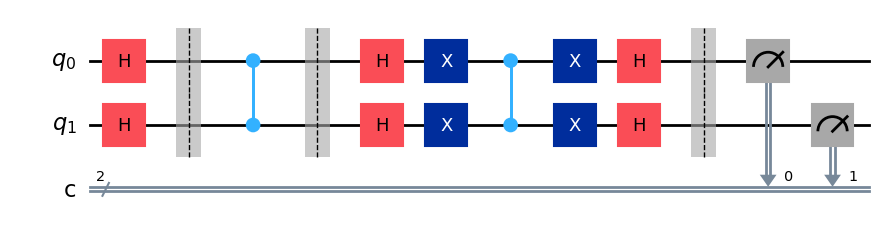

In [51]:
from qiskit import QuantumCircuit
from qiskit import transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import math

# Initialization and Superposition
qc = QuantumCircuit(2,2)
qc.h([0, 1])
qc.barrier()

# Oracle for |11⟩
qc.cz(0, 1)
qc.barrier()

# Diffusion Operator
qc.h([0, 1])
qc.x([0, 1])
qc.cz(0, 1)
qc.x([0, 1])
qc.h([0, 1])
qc.barrier()

# Measurement
qc.measure([0, 1], [0, 1])

# Circuit visualization
qc.draw('mpl')

In [52]:
# Execution
simulator = AerSimulator()
result = simulator.run(qc, shots=1000).result()
counts = result.get_counts()
print("Measurement counts:", counts)

Measurement counts: {'11': 1000}


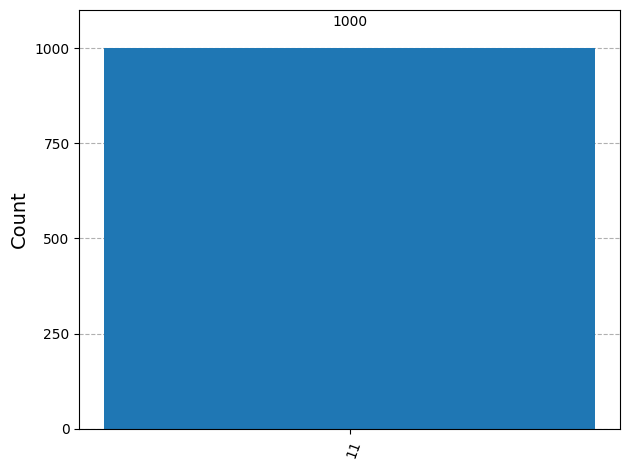

In [53]:
# Plot histogram
display(plot_histogram(counts))

The execution of the circuit shows that the measurement outcomes are dominated by the state $|11\rangle$, confirming that the algorithm successfully identifies the marked element.

Now we will use more qbits, n=4. That way there will be $N=2^4=16$ possible states. For the difussion and the oracle, we will import the oracle_nq and diffusion_nq function from utils.

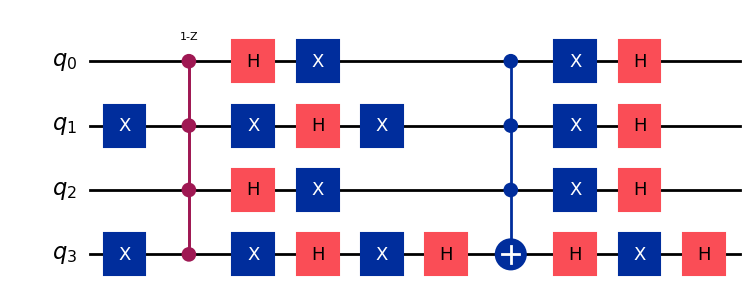

In [54]:
from utils.diffusion import diffusion_nq
from utils.oracle import grover_oracle

nqbits = 4
input_list = ["0101"]

oracle_diffusion = grover_oracle(input_list)
oracle_diffusion.compose(diffusion_nq(nqbits), inplace=True)
oracle_diffusion.draw("mpl")

We need to calculate the optimal number of iterations

In [55]:
optimal_num_iterations = math.floor(
    (math.pi / 4) * math.sqrt(2**nqbits / len(input_list)) - 0.5
)
print(optimal_num_iterations)

2


Finally, we can build the whole circuit

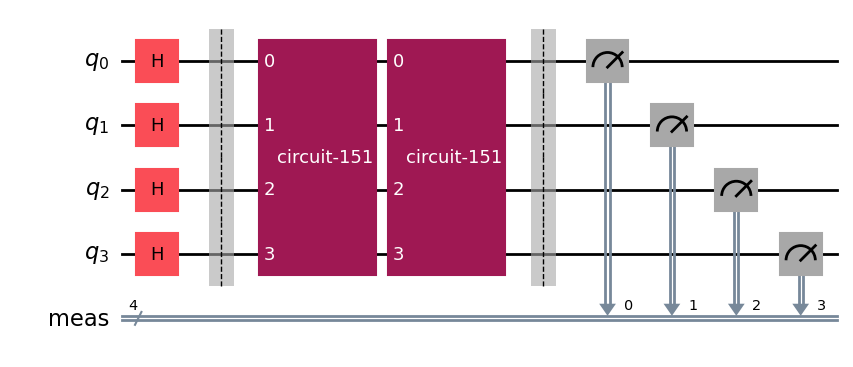

In [56]:
# Initialization and Superposition
qc = QuantumCircuit(nqbits)
qc.h(range(nqbits))
qc.barrier()
# Apply the combined oracle and diffusion operator the optimal number of times
qc.compose(oracle_diffusion.power(optimal_num_iterations), inplace=True)
# Measure all qubits
qc.measure_all()
qc.draw(output="mpl")

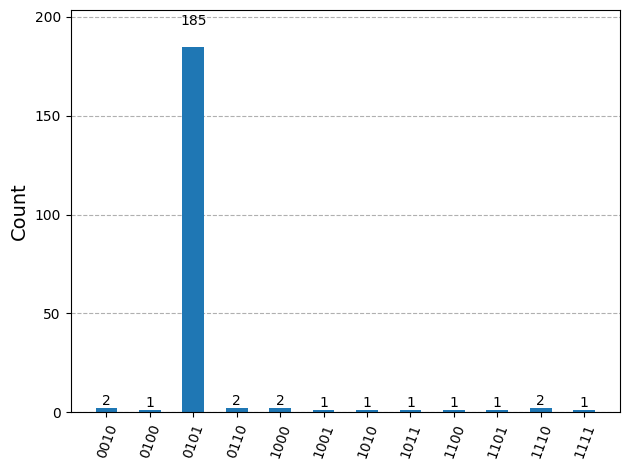

In [ ]:
simulator = AerSimulator()
qc_t = transpile(qc, simulator) 
result = simulator.run(qc_t, shots=200).result()
counts = result.get_counts()
display(plot_histogram(counts))

Note that grover_oracle takes a list as an argument, allowing us to search for multiple items simultaneously.

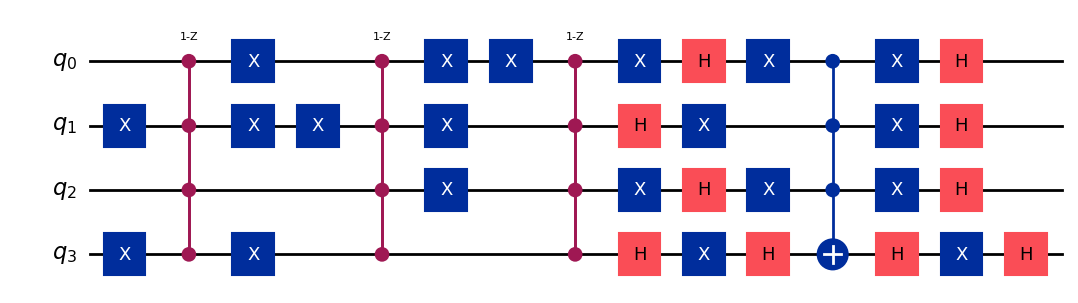

In [58]:
nqbits = 4
input_list = ["0101", "1100", "1010"]

oracle_diffusion = grover_oracle(input_list)
oracle_diffusion.compose(diffusion_nq(nqbits), inplace=True)
oracle_diffusion.draw("mpl")

In [59]:
optimal_num_iterations = math.floor(
    (math.pi / 4) * math.sqrt(2**nqbits / len(input_list)) - 0.5
)
print(optimal_num_iterations)

1


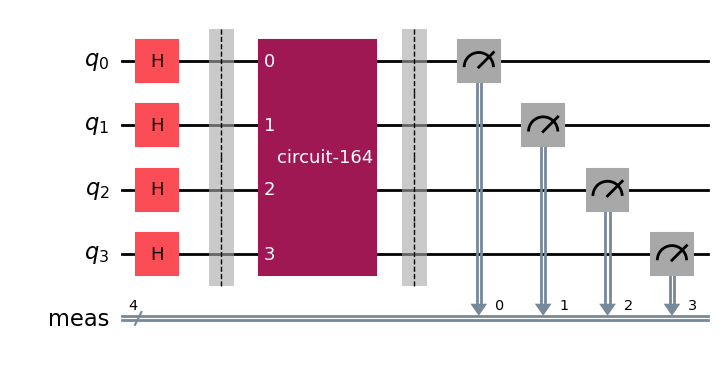

In [60]:
# Initialization and Superposition
qc = QuantumCircuit(nqbits)
qc.h(range(nqbits))
qc.barrier()
# Apply the combined oracle and diffusion operator the optimal number of times
qc.compose(oracle_diffusion.power(optimal_num_iterations), inplace=True)
# Measure all qubits
qc.measure_all()
qc.draw(output="mpl")

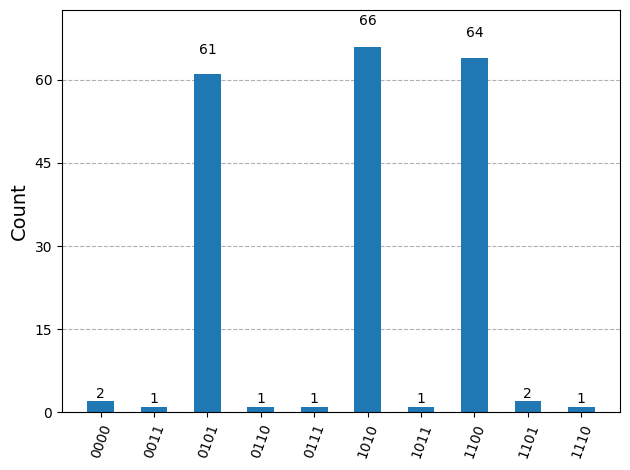

In [61]:
simulator = AerSimulator()
qc_t = transpile(qc, simulator) 
result = simulator.run(qc_t, shots=200).result()
counts = result.get_counts()
display(plot_histogram(counts))

# 6. Simulation with Noise Models

In this section, we analyze the performance of Grover’s algorithm under **artificial noise models**. These simulations do not correspond to a specific quantum device, but instead introduce controlled levels of noise in order to qualitatively study how decoherence, gate errors, and readout errors affect the algorithm’s success probability.

This artificial noise analysis serves as an intermediate step between ideal, noise-free simulations and executions on **real quantum hardware**, which are affected by hardware-specific noise characteristics. In the following sections, the algorithm will be executed on actual quantum devices, allowing for a direct comparison between ideal simulations, artificial noise models, and real experimental results.

In [63]:
from qiskit_aer.noise import NoiseModel, depolarizing_error, ReadoutError
from qiskit import transpile

In [64]:
# Create a noise model
noise_model = NoiseModel()

# Depolarizing errors
error_1q = depolarizing_error(0.001, 1)  # 0.1% error for 1-qubit gates
error_2q = depolarizing_error(0.01, 2)   # 1% error for 2-qubit gates

noise_model.add_all_qubit_quantum_error(error_1q, ['h', 'x'])
noise_model.add_all_qubit_quantum_error(error_2q, ['cx', 'mcx'])

# Readout error
readout_error = ReadoutError([[0.98, 0.02],
                              [0.03, 0.97]])
noise_model.add_all_qubit_readout_error(readout_error)


In [65]:
simulator = AerSimulator(noise_model=noise_model)

qc_t = transpile(qc, simulator)
result = simulator.run(qc_t, shots=1000).result()

counts_noisy = result.get_counts()
print("Noisy measurement counts:", counts_noisy)


Noisy measurement counts: {'1000': 26, '0011': 6, '1100': 274, '1010': 264, '0101': 287, '1110': 16, '0111': 15, '1101': 28, '1001': 7, '0001': 11, '0100': 20, '0110': 8, '0010': 9, '1011': 11, '0000': 13, '1111': 5}


In [66]:
ideal_sim = AerSimulator()
ideal_result = ideal_sim.run(transpile(qc, ideal_sim), shots=1000).result()
counts_ideal = ideal_result.get_counts()

print("Ideal counts:", counts_ideal)
print("Noisy counts:", counts_noisy)


Ideal counts: {'0011': 6, '1100': 304, '1010': 332, '0101': 313, '0010': 4, '1101': 6, '0000': 3, '1000': 3, '0111': 4, '0100': 4, '1001': 1, '1011': 6, '1110': 7, '0110': 3, '0001': 3, '1111': 1}
Noisy counts: {'1000': 26, '0011': 6, '1100': 274, '1010': 264, '0101': 287, '1110': 16, '0111': 15, '1101': 28, '1001': 7, '0001': 11, '0100': 20, '0110': 8, '0010': 9, '1011': 11, '0000': 13, '1111': 5}


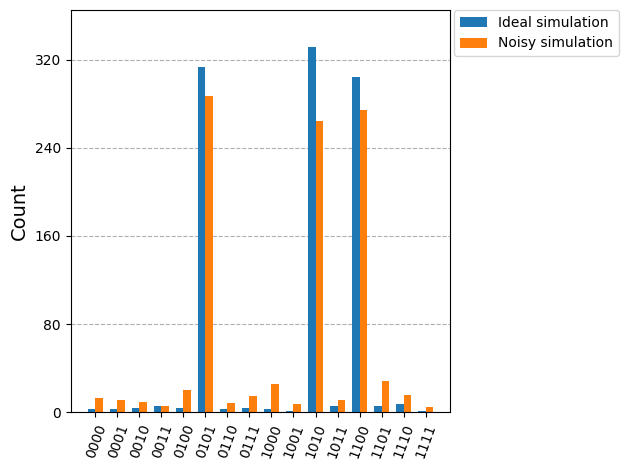

In [69]:
from qiskit.visualization import plot_histogram
from IPython.display import display

fig = plot_histogram(
    [counts_ideal, counts_noisy],
    legend=["Ideal simulation", "Noisy simulation"],
    bar_labels=False
)

display(fig)


# 7. Simulation in real quantum hardware

# 8. Conclusions